In [94]:
##################chapter06_begins########################
import os
PROJECT = 'zeta-sol-254211' # REPLACE WITH YOUR PROJECT ID
BUCKET = 'zeta-sol-254211bucket' # REPLACE WITH YOUR BUCKET NAME
REGION = 'asia-south1-a' # REPLACE WITH YOUR BUCKET REGION e.g. us-central1

os.environ['BUCKET'] = BUCKET

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import google.datalab.bigquery as bq

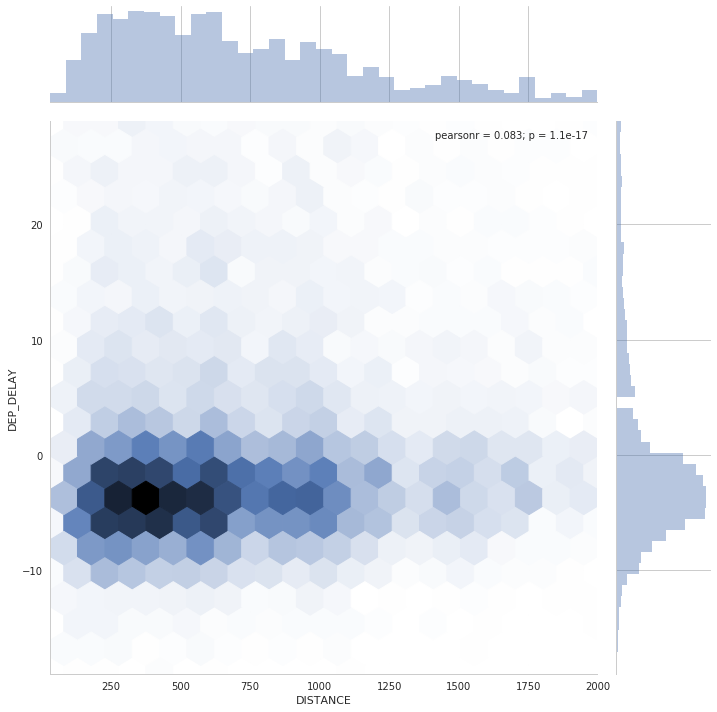

In [96]:
sql = """
SELECT DISTANCE, DEP_DELAY
FROM `flights.tzcorr`
WHERE RAND() < 0.001 AND dep_delay > -20
    AND dep_delay < 30 AND distance < 2000
"""
df = bq.Query(sql).execute().result().to_dataframe()
sns.set_style("whitegrid")
g = sns.jointplot(df['DISTANCE'], df['DEP_DELAY'], kind="hex",
                  size=10, joint_kws={'gridsize':20})

In [97]:
print spark

In [98]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("Bayes classification using Spark") \
    .getOrCreate()

In [99]:
print spark

In [100]:
from pyspark.sql.types import StringType, FloatType, StructType, StructField

header = 'FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,DISTANCE,DEP_AIRPORT_LAT,DEP_AIRPORT_LON,DEP_AIRPORT_TZOFFSET,ARR_AIRPORT_LAT,ARR_AIRPORT_LON,ARR_AIRPORT_TZOFFSET,EVENT,NOTIFY_TIME'

def get_structfield(colname):
   if colname in ['ARR_DELAY', 'DEP_DELAY', 'DISTANCE']:
      return StructField(colname, FloatType(), True)
   else:
      return StructField(colname, StringType(), True)

schema = StructType([get_structfield(colname) for colname in header.split(',')])
print schema

StructType(List(StructField(FL_DATE,StringType,true),StructField(UNIQUE_CARRIER,StringType,true),StructField(AIRLINE_ID,StringType,true),StructField(CARRIER,StringType,true),StructField(FL_NUM,StringType,true),StructField(ORIGIN_AIRPORT_ID,StringType,true),StructField(ORIGIN_AIRPORT_SEQ_ID,StringType,true),StructField(ORIGIN_CITY_MARKET_ID,StringType,true),StructField(ORIGIN,StringType,true),StructField(DEST_AIRPORT_ID,StringType,true),StructField(DEST_AIRPORT_SEQ_ID,StringType,true),StructField(DEST_CITY_MARKET_ID,StringType,true),StructField(DEST,StringType,true),StructField(CRS_DEP_TIME,StringType,true),StructField(DEP_TIME,StringType,true),StructField(DEP_DELAY,FloatType,true),StructField(TAXI_OUT,StringType,true),StructField(WHEELS_OFF,StringType,true),StructField(WHEELS_ON,StringType,true),StructField(TAXI_IN,StringType,true),StructField(CRS_ARR_TIME,StringType,true),StructField(ARR_TIME,StringType,true),StructField(ARR_DELAY,FloatType,true),StructField(CANCELLED,StringType,true)

In [101]:
from pyspark.sql.types import *

def get_structfield(colname):
   if colname in ['ARR_DELAY', 'DEP_DELAY', 'DISTANCE']:
      return StructField(colname, FloatType(), True)
   else:
      return StructField(colname, StringType(), True)

schema = StructType([get_structfield(colname) \
                     for colname in header.split(',')])

In [102]:
inputs = 'gs://zeta-sol-254211bucket/flights/tzcorr/all_flights-*'
flights = spark.read\
            .schema(schema)\
            .csv(inputs)

In [106]:
inputs = 'gs://zeta-sol-254211bucket/flights/tzcorr/all_flights-00000-*'
flights = spark.read\
            .schema(schema)\
            .csv(inputs)

In [108]:
flights.createOrReplaceTempView('flights')

In [109]:
results = spark.sql('SELECT COUNT(*) FROM flights WHERE dep_delay > -20 AND distance < 2000')
results.show()

+--------+
|count(1)|
+--------+
|  581066|
+--------+



In [110]:
traindays = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv('gs://{}/flights/trainday.csv'.format(BUCKET))

traindays.createOrReplaceTempView('traindays')

In [111]:
results = spark.sql('SELECT * FROM traindays')
results.head(5)

[Row(FL_DATE=datetime.datetime(2015, 1, 1, 0, 0), is_train_day=True),
 Row(FL_DATE=datetime.datetime(2015, 1, 2, 0, 0), is_train_day=False),
 Row(FL_DATE=datetime.datetime(2015, 1, 3, 0, 0), is_train_day=False),
 Row(FL_DATE=datetime.datetime(2015, 1, 4, 0, 0), is_train_day=True),
 Row(FL_DATE=datetime.datetime(2015, 1, 5, 0, 0), is_train_day=True)]

In [112]:
statement = """
SELECT
  f.FL_DATE AS date,
  distance,
  dep_delay
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day AND
  f.dep_delay IS NOT NULL
ORDER BY
  f.dep_delay DESC
"""
flights = spark.sql(statement)

In [113]:
df = flights[(flights['distance'] < 2000) & \
    (flights['dep_delay'] > -20) & \
    (flights['dep_delay'] < 30)]
df.describe().show()

+-------+----------+-----------------+-------------------+
|summary|      date|         distance|          dep_delay|
+-------+----------+-----------------+-------------------+
|  count|    373302|           373302|             373302|
|   mean|      null| 713.867102238938|0.29158697247804727|
| stddev|      null|440.6793251347702|  8.514930750419305|
|    min|2015-03-01|             31.0|              -19.0|
|    max|2015-05-24|           1999.0|               29.0|
+-------+----------+-----------------+-------------------+



In [ ]:
pdf = df.sample(False, 0.02, 20).toPandas()
g = sns.jointplot(pdf['distance'], pdf['dep_delay'], kind="hex",
                  size=10, joint_kws={'gridsize':20})

In [ ]:
distthresh = flights.approxQuantile('distance', list(np.arange(0, 1.0, 0.1)), 0.02)
distthresh

In [ ]:
delaythresh = flights.approxQuantile('dep_delay', list(np.arange(0, 1.0, 0.1)), 0.05)
delaythresh

In [ ]:
results = spark.sql('SELECT COUNT(*) FROM flights' +
     ' WHERE dep_delay >= 3 AND dep_delay < 8 AND' +
     ' distance >= 447 AND distance < 557')
results.show()

In [ ]:
inputs = 'gs://zeta-sol-254211bucket/flights/tzcorr/all_flights-*'
flights = spark.read\
            .schema(schema)\
            .csv(inputs)

In [ ]:
flights.createOrReplaceTempView('flights')

In [ ]:
%bash
gsutil cat gs://zeta-sol-254211bucket/flights/pigoutput/part-*

In [ ]:
%bash
gsutil cat gs://zeta-sol-254211bucket/flights/pigoutput2/part-*

In [114]:
%bash
gsutil cat gs://zeta-sol-254211bucket/flights/pigoutput22/part-*

368,15
575,17
838,18
1218,18
9999,19


In [ ]:
###################going_to_chapter05#######################
!pwd

In [ ]:
!pip freeze

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import google.datalab.bigquery as bq

In [ ]:
!pip install google-cloud

In [ ]:
%bash
apt-get install debian-archive-keyring
apt-get install debian-keyring
apt-get -y upgrade
apt-get -y install python-mpltoolkits.basemap
apt-get install -y --no-install-recommends apt-utils

In [115]:
%bigquery schema --table flights.tzcorr

In [117]:
import google.datalab.bigquery as bq
sql = """
SELECT ARR_DELAY, DEP_DELAY
FROM `flights.tzcorr`
WHERE DEP_DELAY > 10 AND RAND() < 0.01
"""
df = bq.Query(sql).execute().result().to_dataframe()

In [118]:
df.describe()

,ARR_DELAY,DEP_DELAY
count,27103.000000,27260.000000
mean,48.092536,53.167792
std,65.684756,63.268399
min,-45.000000,11.000000
25%,12.000000,18.000000
50%,28.000000,32.000000
75%,61.000000,63.000000
max,1235.000000,1221.000000


/usr/local/envs/py2env/lib/python2.7/site-packages/seaborn/categorical.py:584: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/envs/py2env/lib/python2.7/site-packages/seaborn/categorical.py:812: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


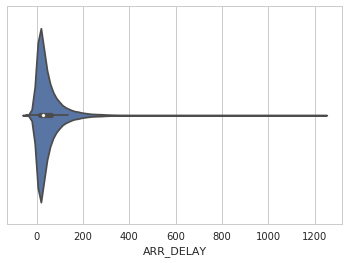

In [119]:
sns.set_style("whitegrid")
ax = sns.violinplot(data=df, x='ARR_DELAY', inner='box', orient='h')

In [120]:
sql = """
SELECT ARR_DELAY, DEP_DELAY
FROM `flights.tzcorr`
WHERE RAND() < 0.001
"""
df = bq.Query(sql).execute().result().to_dataframe()

In [121]:
df['ontime'] = df['DEP_DELAY'] < 10

(-50, 200)

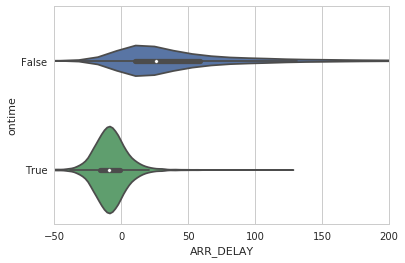

In [122]:
ax = sns.violinplot(data=df, x='ARR_DELAY', y='ontime',
                    inner='box', orient='h')
ax.set_xlim(-50, 200)

(-50, 200)

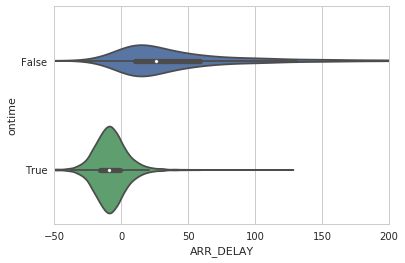

In [123]:
ax = sns.violinplot(data=df, x='ARR_DELAY', y='ontime',
inner='box', orient='h', gridsize=1000)
ax.set_xlim(-50, 200)

In [140]:
depdelayquery = """
SELECT
  DEP_DELAY,
  arrival_delay,
  stddev_arrival_delay,
  numflights
FROM (
  SELECT
    DEP_DELAY,
    AVG(ARR_DELAY) AS arrival_delay,
    STDDEV(ARR_DELAY) AS stddev_arrival_delay,
    COUNT(ARR_DELAY) AS numflights
  FROM
    `flights.tzcorr`
  GROUP BY
    DEP_DELAY )
WHERE
  numflights > 370
ORDER BY
  DEP_DELAY
"""

In [138]:
depdelay = bq.Query(depdelayquery).execute().result().to_dataframe()
depdelay[:5]

,DEP_DELAY,arrival_delay,stddev_arrival_delay,numflights
0,-26.0,-24.430288,11.639358,416
1,-25.0,-24.915937,10.761690,571
2,-24.0,-24.143229,11.940653,768
3,-23.0,-24.006387,11.094486,1096
4,-22.0,-23.337270,12.314511,1524


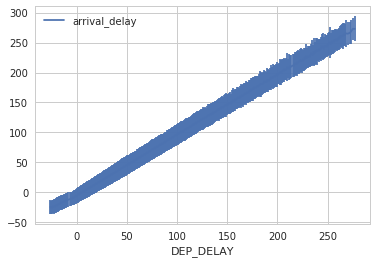

In [129]:
ax = depdelay.plot(kind='line', x='DEP_DELAY',
              y='arrival_delay', yerr='stddev_arrival_delay')

In [130]:
%bigquery create dataset -n temp_dataset
%bigquery execute -q depdelayquery -t my_temp_dataset.delays

In [131]:
for table in bq.Dataset("temp_dataset").tables():
  table.delete()
bq.Dataset("temp_dataset").delete()

/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0,0.5,u'> 30% likelihood of this Arrival Delay (minutes)')

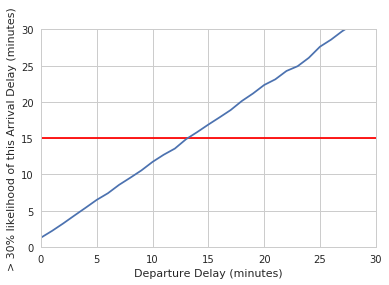

In [132]:
Z_30 = 0.52
depdelay['arr_delay_30'] = (Z_30 * depdelay['stddev_arrival_delay']) \
             + depdelay['arrival_delay']
plt.axhline(y=15, color='r')
ax = plt.axes()
depdelay.plot(kind='line', x='DEP_DELAY', y='arr_delay_30',
              ax=ax, ylim=(0,30), xlim=(0,30), legend=False)
ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('> 30% likelihood of this Arrival Delay (minutes)')

In [136]:
depdelayquery2 = """
SELECT
  DEP_DELAY,
  APPROX_QUANTILES(ARR_DELAY, 101)[OFFSET(70)] AS arrival_delay,
  COUNT(ARR_DELAY) AS numflights
FROM
  `flights.tzcorr`
GROUP BY
  DEP_DELAY
HAVING
  numflights > 370
ORDER BY
  DEP_DELAY
  """

In [139]:
depdelay = bq.Query(depdelayquery2).execute().result().to_dataframe()
depdelay[:5]

,DEP_DELAY,arrival_delay,numflights
0,-26.0,-21.0,416
1,-25.0,-21.0,571
2,-24.0,-21.0,768
3,-23.0,-20.0,1096
4,-22.0,-19.0,1524


Text(0,0.5,u'> 30% likelihood of this Arrival Delay (minutes)')

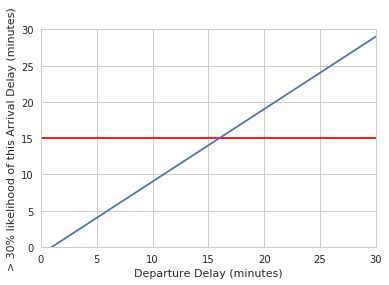

In [137]:
plt.axhline(y=15, color='r')
ax = plt.axes()
depdelay.plot(kind='line', x='DEP_DELAY', y='arrival_delay',
              ax=ax, ylim=(0,30), xlim=(0,30), legend=False)
ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('> 30% likelihood of this Arrival Delay (minutes)')

In [145]:
depdelayquery3 = """
SELECT
  *
FROM (
  SELECT
    DEP_DELAY,
    APPROX_QUANTILES(ARR_DELAY,
      101)[OFFSET(70)] AS arrival_delay,
    COUNT(ARR_DELAY) AS numflights
  FROM
    `zeta-sol-254211.flights.tzcorr` f
  JOIN
    `flights.trainday` t
  ON
    f.FL_DATE = t.FL_DATE
  WHERE
    t.is_train_day = 'True'
  GROUP BY
    DEP_DELAY )
WHERE
  numflights > 370
ORDER BY
  DEP_DELAY
  """

In [146]:
depdelay = bq.Query(depdelayquery3).execute().result().to_dataframe()

Text(0,0.5,u'> 30% likelihood of this Arrival Delay (minutes)')

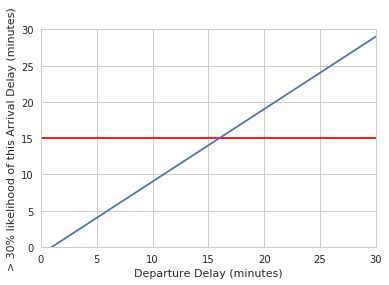

In [148]:
plt.axhline(y=15, color='r')
ax = plt.axes()
depdelay.plot(kind='line', x='DEP_DELAY', y='arrival_delay',
              ax=ax, ylim=(0,30), xlim=(0,30), legend=False)
ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('> 30% likelihood of this Arrival Delay (minutes)')

In [151]:
evalquery = """
SELECT
  SUM(IF(DEP_DELAY < 16
      AND arr_delay < 15, 1, 0)) AS correct_nocancel,
  SUM(IF(DEP_DELAY < 16
      AND arr_delay >= 15, 1, 0)) AS wrong_nocancel,
  SUM(IF(DEP_DELAY >= 16
      AND arr_delay < 15, 1, 0)) AS wrong_cancel,
  SUM(IF(DEP_DELAY >= 16
      AND arr_delay >= 15, 1, 0)) AS correct_cancel
FROM (
  SELECT
    DEP_DELAY,
    ARR_DELAY 
  FROM
    `flights.tzcorr` f
  JOIN
    `flights.trainday` t
  ON
    f.FL_DATE = t.FL_DATE
  WHERE
    t.is_train_day = 'False' )
    """

In [154]:
eval = bq.Query(evalquery).execute().result().to_dataframe()
eval.head()

,correct_nocancel,wrong_nocancel,wrong_cancel,correct_cancel
0,2844868,148220,118949,483430


In [153]:
print eval['correct_nocancel'] / (eval['correct_nocancel'] + \
eval['wrong_nocancel'])
print eval['correct_cancel'] / (eval['correct_cancel'] + \
eval['wrong_cancel'])

0    0.950479
dtype: float64
0    0.802535
dtype: float64


In [156]:
evalquery2 = """
SELECT
  SUM(IF(DEP_DELAY = 15
      AND arr_delay < 15, 1, 0)) AS correct_nocancel,
  SUM(IF(DEP_DELAY = 15
      AND arr_delay >= 15, 1, 0)) AS wrong_nocancel,
  SUM(IF(DEP_DELAY = 16
      AND arr_delay < 15, 1, 0)) AS wrong_cancel,
  SUM(IF(DEP_DELAY = 16
      AND arr_delay >= 15, 1, 0)) AS correct_cancel
FROM (
  SELECT
    DEP_DELAY,
    ARR_DELAY 
  FROM
    `flights.tzcorr` f
  JOIN
    `flights.trainday` t
  ON
    f.FL_DATE = t.FL_DATE
  WHERE
    t.is_train_day = 'False' )
    """

In [157]:
eval = bq.Query(evalquery2).execute().result().to_dataframe()
eval.head()

,correct_nocancel,wrong_nocancel,wrong_cancel,correct_cancel
0,17234,6476,15178,6495


In [158]:
print eval['correct_nocancel'] / (eval['correct_nocancel'] + \
eval['wrong_nocancel'])
print eval['correct_cancel'] / (eval['correct_cancel'] + \
eval['wrong_cancel'])

0    0.726866
dtype: float64
0    0.299682
dtype: float64


In [159]:
####################back_to_chapter_06#################
evalquery3ch06 = """
SELECT
  SUM(IF(DEP_DELAY = 15
      AND arr_delay < 15,
      1,
      0)) AS wrong_cancel,
  SUM(IF(DEP_DELAY = 15
      AND arr_delay >= 15,
      1,
      0)) AS correct_cancel
  FROM (
    SELECT
      DEP_DELAY,
      ARR_DELAY
    FROM
      flights.tzcorr f
    JOIN
      flights.trainday t
    ON
      f.FL_DATE = t.FL_DATE
    WHERE
      t.is_train_day = 'False'
      AND f.DISTANCE < 368)
      """

In [160]:
eval = bq.Query(evalquery3ch06).execute().result().to_dataframe()
eval.head()

,wrong_cancel,correct_cancel
0,3209,1622


In [161]:
print eval['correct_cancel'] / (eval['correct_cancel'] + \
eval['wrong_cancel'])

0    0.335748
dtype: float64
